In [1]:
%cd ..

/home/feodor/Jupyter/depth-poset


/home/feodor/Jupyter/jupyter-env/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import itertools
import inspect
import time

import numpy as np
import pandas as pd
import gudhi as gh
import networkx as nx

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from src.depth import DepthPoset
from src.drow import plot_filtred_complex2d, plot_simplex, enumerate_points

from tqdm import tqdm

# The Simplicial Complex

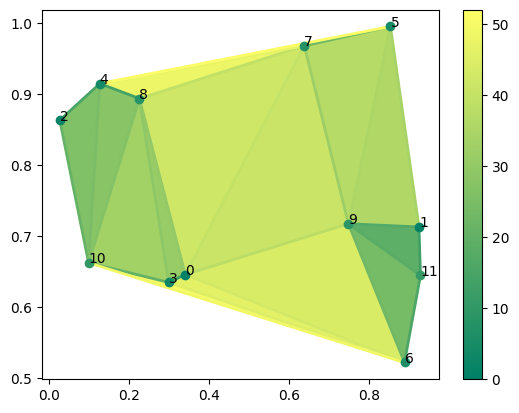

In [3]:
n, dim = 12, 2
points = np.random.random([n, dim])

stree = gh.AlphaComplex(points).create_simplex_tree()
simplices = [simplex for simplex, value in stree.get_filtration()]
filtration_values = np.asarray([value for simplex, value in stree.get_filtration()])
new_filtration_values = np.argsort(filtration_values)
for simplex, value in zip(simplices, new_filtration_values):
    stree.assign_filtration(simplex, value)

sm = plot_filtred_complex2d(stree, points, cmap='summer')
plt.colorbar(sm, ax=plt.gca())
enumerate_points(points)

# Define and iterate the Transpositions

In [4]:
def order_is_possible(order):
    # returns False if there are bigger simplices before the smallest
    for i0 in range(len(order)):
        for i1 in range(i0 + 1, len(order)):
            s0 = np.sort(order[i0])
            s1 = np.sort(order[i1])
            intersection = np.intersect1d(s0, s1)
            if list(s1) == list(intersection):
                return False
    return True

In [5]:
def iterate_possible_transpositions_indices(order, switch=True):
    # 
    if switch:
        generator = np.transpose([np.arange(len(order) - 1), np.arange(len(order) - 1) + 1])
    else:
        generator = itertools.combinations(range(len(order)), 2)
    for i0, i1 in generator:
        new_order = order.copy()
        new_order[i0], new_order[i1] = new_order[i1], new_order[i0]
        if order_is_possible(new_order):
            yield i0, i1

In [6]:
def get_transposition_type(stree: gh.SimplexTree, s0, s1):
    """
    Returns the type of the transpositon (birth-birth, death-deat, birth-death, another) of 2 simplices: s0 and s1
    """
    s0, s1 = tuple(np.sort(s0)), tuple(np.sort(s1))
    try:
        pairs = stree.persistence_pairs()
    except AssertionError:
        stree.compute_persistence()
        pairs = stree.persistence_pairs() 
    births = [tuple(np.sort(pair[0])) for pair in pairs]
    deaths = [tuple(np.sort(pair[1])) for pair in pairs]
    if s0 in births and s1 in births:
        return 'birth-birth'
    if s0 in deaths and s1 in deaths:
        return 'death-death'
    if s0 in births and s1 in deaths:
        return 'birth-death'
    if s0 in deaths and s1 in births:
        return 'birth-death'

In [7]:
def iterate_possible_transpositions(stree: gh.SimplexTree, switch=True, transposition_type=None):
    # 
    order = [simplex for simplex, value in stree.get_filtration()]
    for i0, i1 in iterate_possible_transpositions_indices(order, switch=switch):
        transposition = {'index 0': i0, 
                         'index 1': i1, 
                         'value 0': stree.filtration(order[i0]), 
                         'value 1': stree.filtration(order[i1]), 
                         'simplex 0': order[i0], 
                         'simplex 1': order[i1], 
                         'dim 0': len(order[i0]) - 1, 
                         'dim 1': len(order[i1]) - 1, 
                         'type': get_transposition_type(stree, order[i0], order[i1]), 
                        }
        if (transposition_type is None) or (transposition_type == transposition['type']):
            yield transposition

In [8]:
timer = time.perf_counter()
df_transpositions = pd.DataFrame(iterate_possible_transpositions(stree))
timer = time.perf_counter() - timer

print(f'Transpositions are found in {timer:.4f} seconds.\n')
print(f'Transposition types distribution:\n{
        '\n'.join(str(df_transpositions['type'].value_counts()).split('\n')[1:-1])
        }\n')

print(f'df_transpositions.shape = {df_transpositions.shape}')
df_transpositions.head()

Transpositions are found in 1.2279 seconds.

Transposition types distribution:
birth-birth    14
birth-death    13
death-death    13

df_transpositions.shape = (40, 9)


,index 0,index 1,value 0,value 1,simplex 0,simplex 1,dim 0,dim 1,type
0,0,1,0.0,1.0,[0],[1],0,0,birth-birth
1,1,2,1.0,2.0,[1],[2],0,0,birth-birth
2,2,3,2.0,3.0,[2],[3],0,0,birth-birth
3,3,4,3.0,4.0,[3],[4],0,0,birth-birth
4,4,5,4.0,5.0,[4],[5],0,0,birth-birth


## Plot the Transposition

In [9]:
def plot_transposition(transposition, stree0, stree1, dp0, dp1, figsize=(9, 8), cmap='summer'):
    # returns fig, axs
    s0 = transposition['simplex 0']
    s1 = transposition['simplex 1']
    
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    
    fig.suptitle(f'The {transposition['type'].replace('b', 'B').replace('d', 'D')} Transposition of Simplices {s0} and {s1}')
    axs[0, 0].set_title('Complex before the Transposition')
    axs[0, 1].set_title('Complex after the Transposition')
    axs[1, 0].set_title('Depth Poset before the Transposition')
    axs[1, 1].set_title('Depth Poset after the Transposition')
    
    
    for i, streei in enumerate([stree0, stree1]):
        sm = plot_filtred_complex2d(streei, points, ax=axs[0, i], cmap=cmap, linewidth=4)
        plt.colorbar(sm, ax=axs[0, i])
    
        plot_simplex(s0, points, ax=axs[0, i], color='red', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s0}) = {streei.filtration(s0)}', zorder=4)
        plot_simplex(s1, points, ax=axs[0, i], color='blue', marker='x', linestyle=':', hatch='+', 
                 label=f'f({s1}) = {streei.filtration(s1)}', zorder=4)
        enumerate_points(points, ax=axs[0, i])
        axs[0, i].legend()
    
    for i, dpi in enumerate([dp0, dp1]):
        node_color = ['gold' if tuple(s0) in node.source or tuple(s1) in node.source else 'teal' for node in dpi.nodes]
        nx.draw_networkx(dpi.get_transitive_reduction(), pos=dpi.persistant_layout(), ax=axs[1, i], 
                         node_color=node_color, node_size=36, 
                         labels=dpi.get_labels(), 
                         with_labels=False, hide_ticks=False)
        axs[1, i].fill_between([0, max(dpi.get_filtration_values())], 
                               [0, max(dpi.get_filtration_values())], [0, 0], color='lightgrey')
        axs[1, i].set_xlim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))
        axs[1, i].set_ylim(*(max(dpi.get_filtration_values())*np.array([-0.05, 1.05])))

    return fig, axs

In [10]:
def get_strees(transposition, stree: gh.SimplexTree):
    # returns 2 SimplexTrees, before and after the transposition
    s0, s1 = transposition['simplex 0'], transposition['simplex 1']
    v0, v1 = transposition['value 0'], transposition['value 1']
    stree0 = stree.copy()
    stree1 = stree.copy()
    stree1.assign_filtration(s1, v0)
    stree1.assign_filtration(s0, v1)
    return stree0, stree1

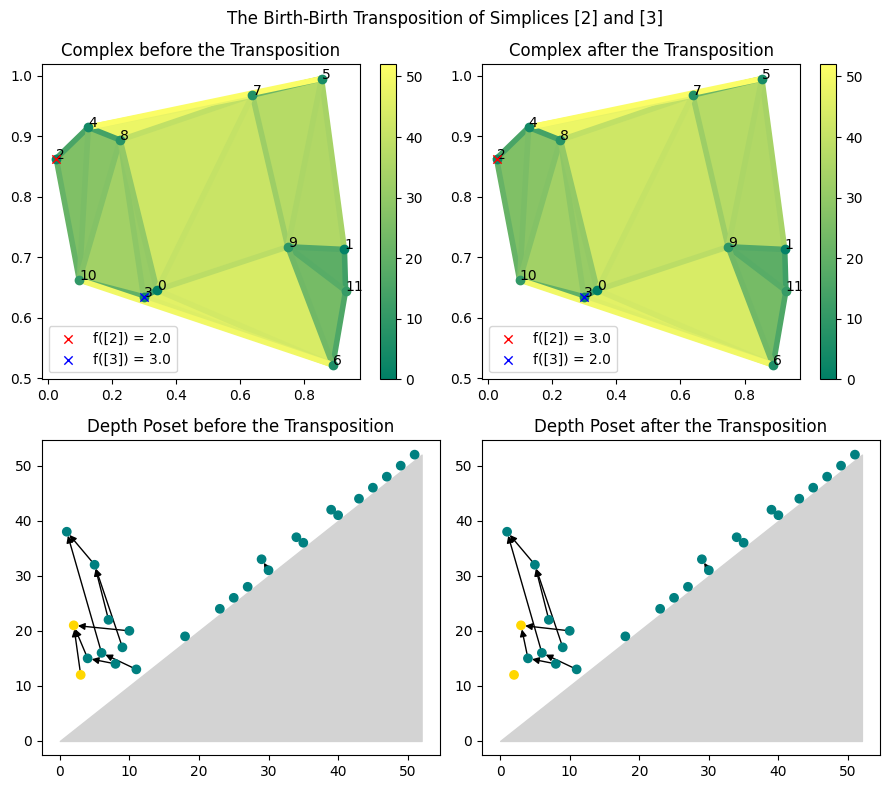

In [11]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions.index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1)
plt.tight_layout()
plt.show()

# Basic Set Difference Measures

In [12]:
def jacard_index(a, b):
    """
    Calculate the Jaccard index
    """
    intersection = set(a) & set(b)
    union = set(a) | set(b)
    if len(union) == 0:
        return 1
    return len(intersection) / len(union)

# Lemmas and Hypothesises

Write $\text{Succ}(s, t) = \text{Succ}'(s, t) = \text{Succ}''(s, t)$ for the succesors and $\text{Pred}(s, t) = \text{Pred}'(s, t) = \text{Pred}''(s, t)$ for the predecessors (ancessors) of the pair in $D$, $D'$, $D''$, respectively.

Since $D = D' \cup D''$, we also have $\text{Succ}(s, t) = \text{Succ}'(s, t) \cup \text{Succ}''(s, t)$ and $\text{Pred}(s, t) = \text{Pred}'(s, t) \cup \text{Pred}''(s, t)$.

## Lemma 3.1.
Suppose $(x, y)$ and $(a, b)$ are birth-death pairs of $f: X\to R$, $a, x$ are consecutive in the ordering of the cellls by $f$, and the transposition $a, x$ is a switch. Then
$$
\text{Succ}'(a, y) = \{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}
$$
$$
\text{Succ}'(x, b) = \{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}
$$


Let's denote these sets:
1. $\text{Succ}'(a, y)$ - __l31_set0__
2. $\{(x, b)\}$ - __l31_set1__
3. $\text{Succ}'(a, b)$ - __l31_set2__
4. $\{(s, t)\in \text{Succ}'(x, y) | f(t)<f(b)\}$ - __l31_set3__
5. $\text{Succ}'(x, b)$ - __l31_set4__
6. $\{(s, t)\in \text{Succ}'(x, y) | f(t) > f(b)\}$ - __l31_set5__

Now the Lemma 3.1 will be look like
$$
    \textbf{l31\_set0} = \textbf{l31\_set1} \cup \textbf{l31\_set2} \cup \textbf{l31\_set3} 
$$
$$
    \textbf{l31\_set4} = \textbf{l31\_set5}
$$

In [13]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[df_transpositions['type'] == 'birth-birth'].index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

transposition

index 0                2
index 1                3
value 0              2.0
value 1              3.0
simplex 0            [2]
simplex 1            [3]
dim 0                  0
dim 1                  0
type         birth-birth
Name: 2, dtype: object

In [14]:
pd.DataFrame({'dp0-bd': [(n.birth_value, n.death_value)  for n in dp0.nodes], 
              'dp1-bd': [(n.birth_value, n.death_value)  for n in dp1.nodes], 
              'dp0-source': [n.source for n in dp0.nodes], 
              'dp1-source': [n.source for n in dp1.nodes], 
              })

,dp0-bd,dp1-bd,dp0-source,dp1-source
0,"(51.0, 52.0)","(51.0, 52.0)","((4, 5), (4, 5, 7))","((4, 5), (4, 5, 7))"
1,"(49.0, 50.0)","(49.0, 50.0)","((6, 10), (3, 6, 10))","((6, 10), (3, 6, 10))"
2,"(47.0, 48.0)","(47.0, 48.0)","((4, 7), (4, 7, 8))","((4, 7), (4, 7, 8))"
3,"(45.0, 46.0)","(45.0, 46.0)","((3, 6), (0, 3, 6))","((3, 6), (0, 3, 6))"
4,"(43.0, 44.0)","(43.0, 44.0)","((0, 6), (0, 6, 9))","((0, 6), (0, 6, 9))"
5,"(40.0, 41.0)","(40.0, 41.0)","((0, 7), (0, 7, 9))","((0, 7), (0, 7, 9))"
6,"(39.0, 42.0)","(39.0, 42.0)","((7, 8), (0, 7, 8))","((7, 8), (0, 7, 8))"
7,"(35.0, 36.0)","(35.0, 36.0)","((5, 9), (1, 5, 9))","((5, 9), (1, 5, 9))"
8,"(34.0, 37.0)","(34.0, 37.0)","((1, 5), (5, 7, 9))","((1, 5), (5, 7, 9))"
9,"(30.0, 31.0)","(30.0, 31.0)","((0, 8), (0, 3, 8))","((0, 8), (0, 3, 8))"


In [15]:
def get_abxy_bb(transposition, dp0: DepthPoset):
    # 
    if transposition['type'] != 'birth-birth':
        return None
    for node in dp0.nodes:
        if node.birth_value == transposition['value 0']:
            a = node.birth_value
            b = node.death_value
        if node.birth_value == transposition['value 1']:
            x = node.birth_value
            y = node.death_value
    return a, b, x, y

In [16]:
def l31_set0(transposition, dp0: DepthPoset, dp1: DepthPoset):
    r"""
    $\text{Succ}'(a, y)$
    """
    a, b, x, y = get_abxy_bb(transposition, dp0)
    for node in dp1.nodes:
        if (node.birth_value == a) and (node.death_value == y):
            node_ay = node
            break
    node_condition = lambda other: dp1.lower(other, node_ay)
    dp_res = dp1.get_column_bottom_to_top_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [17]:
l31_set0(transposition, dp0, dp1)

[]

In [18]:
def l31_set1(transposition, dp0: DepthPoset):
    r"""
    $\{(x, b)\}$
    """
    a, b, x, y = get_abxy_bb(transposition, dp0)
    return [(x, b)]

In [19]:
l31_set1(transposition, dp0)

[(3.0, 21.0)]

In [20]:
def l31_set2(transposition, dp0: DepthPoset):
    r"""
    $\text{Succ}'(a, b)$
    """
    a, b, x, y = get_abxy_bb(transposition, dp0)
    for node in dp0.nodes:
        if (node.birth_value == a) and (node.death_value == b):
            node_ab = node
            break
    node_condition = lambda other: dp0.lower(other, node_ab)
    dp_res = dp0.get_column_bottom_to_top_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [21]:
l31_set2(transposition, dp0)

[(10.0, 20.0), (8.0, 14.0), (4.0, 15.0), (3.0, 12.0)]

In [22]:
def l31_set3(transposition, dp0: DepthPoset):
    r"""
    $\{(s, t) \in \text{Succ}'(x, y): f(t) < f(b)\}$
    """
    a, b, x, y = get_abxy_bb(transposition, dp0)
    for node in dp0.nodes:
        if (node.birth_value == x) and (node.death_value == y):
            node_xy = node
            break
    node_condition = lambda other: dp0.lower(other, node_xy) and other.death_value < b
    dp_res = dp0.get_column_bottom_to_top_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [23]:
l31_set3(transposition, dp0)

[]

In [24]:
def l31_set4(transposition, dp0: DepthPoset, dp1: DepthPoset):
    """
    $\text{Succ}'(x, b)$
    """
    a, b, x, y = get_abxy_bb(transposition, dp0)
    for node in dp1.nodes:
        if (node.birth_value == x) and (node.death_value == b):
            node_xb = node
            break
    node_condition = lambda other: dp1.lower(other, node_xb)
    dp_res = dp1.get_column_bottom_to_top_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [25]:
l31_set4(transposition, dp0, dp1)

[(10.0, 20.0), (8.0, 14.0), (4.0, 15.0)]

In [26]:
def l31_set5(transposition, dp0: DepthPoset):
    r"""
    $\{(s, t) \in \text{Succ}'(x, y): f(t) > f(b)\}$
    """
    a, b, x, y = get_abxy_bb(transposition, dp0)
    for node in dp0.nodes:
        if (node.birth_value == x) and (node.death_value == y):
            node_xy = node
            break
    node_condition = lambda other: dp0.lower(other, node_xy) and other.death_value > b
    dp_res = dp0.get_column_bottom_to_top_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [27]:
l31_set5(transposition, dp0)

[]

In [28]:
fs = [l31_set0, l31_set1, l31_set2, l31_set3, l31_set4, l31_set5]
sets = [] 
for f in fs:
    try:
        sets.append(f(transposition, dp0, dp1))
    except TypeError:
        sets.append(f(transposition, dp0))
pd.DataFrame({'Name': [f.__name__ for f in fs], 
              'Arguments': [inspect.signature(f).parameters for f in fs],
              'Description': [f.__doc__.strip() for f in fs], 
              'Contain': [set(s) for s in sets], 
             })

,Name,Arguments,Description,Contain
0,l31_set0,"(transposition, dp0, dp1)","$\text{Succ}'(a, y)$",{}
1,l31_set1,"(transposition, dp0)","$\{(x, b)\}$","{(3.0, 21.0)}"
2,l31_set2,"(transposition, dp0)","$\text{Succ}'(a, b)$","{(4.0, 15.0), (8.0, 14.0), (3.0, 12.0), (10.0,..."
3,l31_set3,"(transposition, dp0)","$\{(s, t) \in \text{Succ}'(x, y): f(t) < f(b)\}$",{}
4,l31_set4,"(transposition, dp0, dp1)","$\text{Succ}'(x, b)$","{(4.0, 15.0), (8.0, 14.0), (10.0, 20.0)}"
5,l31_set5,"(transposition, dp0)","$\{(s, t) \in \text{Succ}'(x, y): f(t) > f(b)\}$",{}


In [29]:
def jacard_l31a(transposition, dp0: DepthPoset, dp1: DepthPoset):
    r"""
    Jacard index of the sets:
    $\text{Succ}'(a, y)$
    and
    $\{(x, b)\} \cup \text{Succ}'(a, b) \cup \{(s, t) \in \text{Succ}'(x, y): f(t) < f(b)\}$
    
    This should be 1 for Birth-birth transposition, if Lemma 3.1. is True.
    """
    if transposition['type'] != 'birth-birth':
        return None
    set0 = list(l31_set0(transposition, dp0, dp1))
    set1 = list(l31_set1(transposition, dp0)) + list(l31_set2(transposition, dp0)) + list(l31_set3(transposition, dp0))
    return jacard_index(set0, set1)

In [30]:
def jacard_l31b(transposition, dp0: DepthPoset, dp1: DepthPoset):
    r"""
    Jacard index of the sets:
    $\text{Succ}'(x, b)$
    and
    $\{(s, t) \in \text{Succ}'(x, y): f(t) > f(b)\}$

    This should be 1 for Birth-birth transposition, if Lemma 3.1. is True.
    """
    if transposition['type'] != 'birth-birth':
        return None
    set0 = list(l31_set0(transposition, dp0, dp1))
    set1 = list(l31_set1(transposition, dp0)) + list(l31_set2(transposition, dp0)) + list(l31_set3(transposition, dp0))
    return jacard_index(set0, set1)

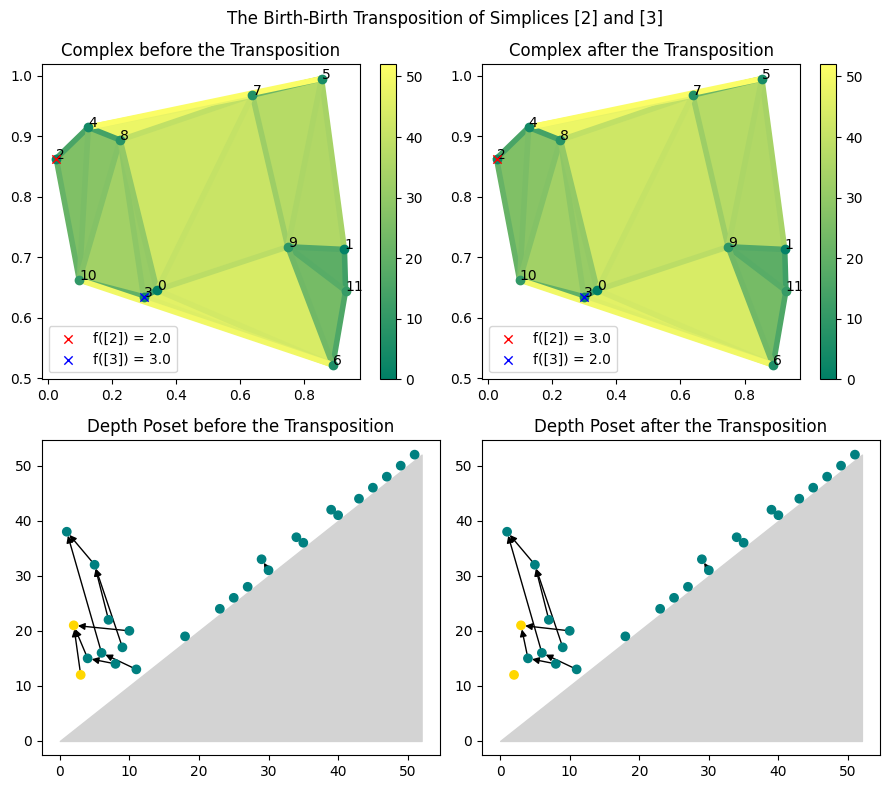

,score,descr,value
0,jacard_l31a,"Jacard index of the sets: $\text{Succ}'(a,...",0.0
1,jacard_l31b,"Jacard index of the sets: $\text{Succ}'(x,...",0.0


In [31]:
fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1)
plt.tight_layout()
plt.show()


pd.DataFrame([{'score': f.__name__, 
               'descr': f.__doc__.replace('\n', ' ').strip(),
               'value': f(transposition, dp0, dp1)
              } for f in [jacard_l31a, jacard_l31b]])

## Lemma 3.2.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f:X\to R$, $y, b$ are consecutive in the ordering by $f$, and transposition of $y, b$ is a switch. Then
$$
\text{Succ}''(x, b) = \{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}
$$
$$
\text{Succ}''(a, y) = \{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}
$$


Let's denote these sets:
1. $\text{Succ}''(x, b)$ - __l32_set0__
2. $\{(a, y)\}$ - __l32_set1__
3. $\text{Succ}''(a, b)$ - __l32_set2__
4. $\{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$ - __l32_set3__
5. $\text{Succ}''(a, y)$ - __l32_set4__
6. $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$ - __l32_set5__

Now the Lemma 3.2 will be look like
$$
    \textbf{l32\_set0} = \textbf{l32\_set1} \cup \textbf{l32\_set2} \cup \textbf{l32\_set3} 
$$
$$
    \textbf{l32\_set4} = \textbf{l32\_set5}
$$

In [32]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[df_transpositions['type'] == 'death-death'].index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

transposition

index 0               37
index 1               38
value 0             37.0
value 1             38.0
simplex 0      [5, 7, 9]
simplex 1         [0, 9]
dim 0                  2
dim 1                  1
type         death-death
Name: 31, dtype: object

In [33]:
pd.DataFrame({'dp0-bd': [(n.birth_value, n.death_value)  for n in dp0.nodes], 
              'dp1-bd': [(n.birth_value, n.death_value)  for n in dp1.nodes], 
              'dp0-source': [n.source for n in dp0.nodes], 
              'dp1-source': [n.source for n in dp1.nodes], 
              })

,dp0-bd,dp1-bd,dp0-source,dp1-source
0,"(51.0, 52.0)","(51.0, 52.0)","((4, 5), (4, 5, 7))","((4, 5), (4, 5, 7))"
1,"(49.0, 50.0)","(49.0, 50.0)","((6, 10), (3, 6, 10))","((6, 10), (3, 6, 10))"
2,"(47.0, 48.0)","(47.0, 48.0)","((4, 7), (4, 7, 8))","((4, 7), (4, 7, 8))"
3,"(45.0, 46.0)","(45.0, 46.0)","((3, 6), (0, 3, 6))","((3, 6), (0, 3, 6))"
4,"(43.0, 44.0)","(43.0, 44.0)","((0, 6), (0, 6, 9))","((0, 6), (0, 6, 9))"
5,"(40.0, 41.0)","(40.0, 41.0)","((0, 7), (0, 7, 9))","((0, 7), (0, 7, 9))"
6,"(39.0, 42.0)","(39.0, 42.0)","((7, 8), (0, 7, 8))","((7, 8), (0, 7, 8))"
7,"(35.0, 36.0)","(35.0, 36.0)","((5, 9), (1, 5, 9))","((5, 9), (1, 5, 9))"
8,"(34.0, 37.0)","(34.0, 38.0)","((1, 5), (5, 7, 9))","((1, 5), (5, 7, 9))"
9,"(30.0, 31.0)","(30.0, 31.0)","((0, 8), (0, 3, 8))","((0, 8), (0, 3, 8))"


In [34]:
def get_abxy_dd(transposition, dp0: DepthPoset):
    # 
    if transposition['type'] != 'death-death':
        return None
    for node in dp0.nodes:
        if node.death_value == transposition['value 0']:
            a = node.birth_value
            b = node.death_value
        if node.death_value == transposition['value 1']:
            x = node.birth_value
            y = node.death_value
    return a, b, x, y

In [35]:
a, b, x, y = get_abxy_dd(transposition, dp0)

print(f'a: {a}')
print(f'b: {b}')
print(f'x: {x}')
print(f'y: {y}')

a: 34.0
b: 37.0
x: 1.0
y: 38.0


In [36]:
def l32_set0(transposition, dp0: DepthPoset, dp1: DepthPoset):
    r"""
    $\text{Succ}''(x, b)$
    """
    a, b, x, y = get_abxy_dd(transposition, dp0)
    for node in dp1.nodes:
        if (node.birth_value == x) and (node.death_value == b):
            node_xb = node
            break
    node_condition = lambda other: dp1.lower(other, node_xb)
    dp_res = dp1.get_row_left_to_right_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [37]:
l32_set0(transposition, dp0, dp1)

[(11.0, 13.0), (9.0, 17.0), (7.0, 22.0), (6.0, 16.0), (5.0, 32.0)]

In [38]:
def l32_set1(transposition, dp0: DepthPoset):
    r"""
    $\{(a, y)\}$
    """
    a, b, x, y = get_abxy_dd(transposition, dp0)
    return [(a, y)]

In [39]:
l32_set1(transposition, dp0)

[(34.0, 38.0)]

In [40]:
def l32_set2(transposition, dp0: DepthPoset):
    r"""
    $\text{Succ}''(a, b)$
    """
    a, b, x, y = get_abxy_dd(transposition, dp0)
    for node in dp0.nodes:
        if (node.birth_value == a) and (node.death_value == b):
            node_ab = node
            break
    node_condition = lambda other: dp0.lower(other, node_ab)
    dp_res = dp0.get_row_left_to_right_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [41]:
l32_set2(transposition, dp0)

[(35.0, 36.0)]

In [42]:
def l32_set3(transposition, dp0: DepthPoset):
    r"""
    $\{(s, t)\in \text{Succ}''(x, y) : f(a) < f(s) < f(x)\}$
    """
    a, b, x, y = get_abxy_dd(transposition, dp0)
    for node in dp0.nodes:
        if (node.birth_value == x) and (node.death_value == y):
            node_xy = node
            break
    node_condition = lambda other: dp0.lower(other, node_xy) and other.birth_value > a and other.birth_value < x
    dp_res = dp0.get_row_left_to_right_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [43]:
l32_set3(transposition, dp0)

[]

In [44]:
def l32_set4(transposition, dp0: DepthPoset, dp1: DepthPoset):
    """
    $\text{Succ}''(a, y)$
    """
    a, b, x, y = get_abxy_dd(transposition, dp0)
    for node in dp1.nodes:
        if (node.birth_value == a) and (node.death_value == y):
            node_ay = node
            break
    node_condition = lambda other: dp1.lower(other, node_ay)
    dp_res = dp1.get_row_left_to_right_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [46]:
l32_set4(transposition, dp0, dp1)

[(35.0, 36.0)]

In [47]:
def l32_set5(transposition, dp0: DepthPoset):
    r"""
    $\{(s, t)\in \text{Succ}''(x, y) | f(s) < f(a)\}$
    """
    a, b, x, y = get_abxy_dd(transposition, dp0)
    for node in dp0.nodes:
        if (node.birth_value == x) and (node.death_value == y):
            node_xy = node
            break
    node_condition = lambda other: dp0.lower(other, node_xy) and other.birth_value < a
    dp_res = dp0.get_row_left_to_right_reduction().subposet(node_condition=node_condition)
    return [(node.birth_value, node.death_value) for node in dp_res.nodes]

In [48]:
l32_set5(transposition, dp0)

[(11.0, 13.0), (9.0, 17.0), (7.0, 22.0), (6.0, 16.0), (5.0, 32.0)]

In [53]:
def jacard_l32a(transposition, dp0: DepthPoset, dp1: DepthPoset):
    r"""
    Jacard index of the sets:
    $\text{Succ}''(x, b)$
    and
    $\{(a, y)\} \cup \text{Succ}''(a, b) \cup \{(s, t)\in \text{Succ}''(x, y) | f(a) < f(s) < f(x)\}$
    
    This should be 1 for Birth-birth transposition, if Lemma 3.2. is True.
    """
    if transposition['type'] != 'death-death':
        return None
    set0 = list(l32_set0(transposition, dp0, dp1))
    set1 = list(l32_set1(transposition, dp0)) + list(l32_set2(transposition, dp0)) + list(l32_set3(transposition, dp0))
    return jacard_index(set0, set1)

In [54]:
def jacard_l32b(transposition, dp0: DepthPoset, dp1: DepthPoset):
    r"""
    Jacard index of the sets:
    $\text{Succ}''(a, y)$
    and
    $\{(s, t)\in\text{Succ}''(x, y) | f(s) < f(a)\}$

    This should be 1 for Birth-birth transposition, if Lemma 3.2. is True.
    """
    if transposition['type'] != 'death-death':
        return None
    set0 = list(l32_set0(transposition, dp0, dp1))
    set1 = list(l32_set1(transposition, dp0)) + list(l32_set2(transposition, dp0)) + list(l32_set3(transposition, dp0))
    return jacard_index(set0, set1)

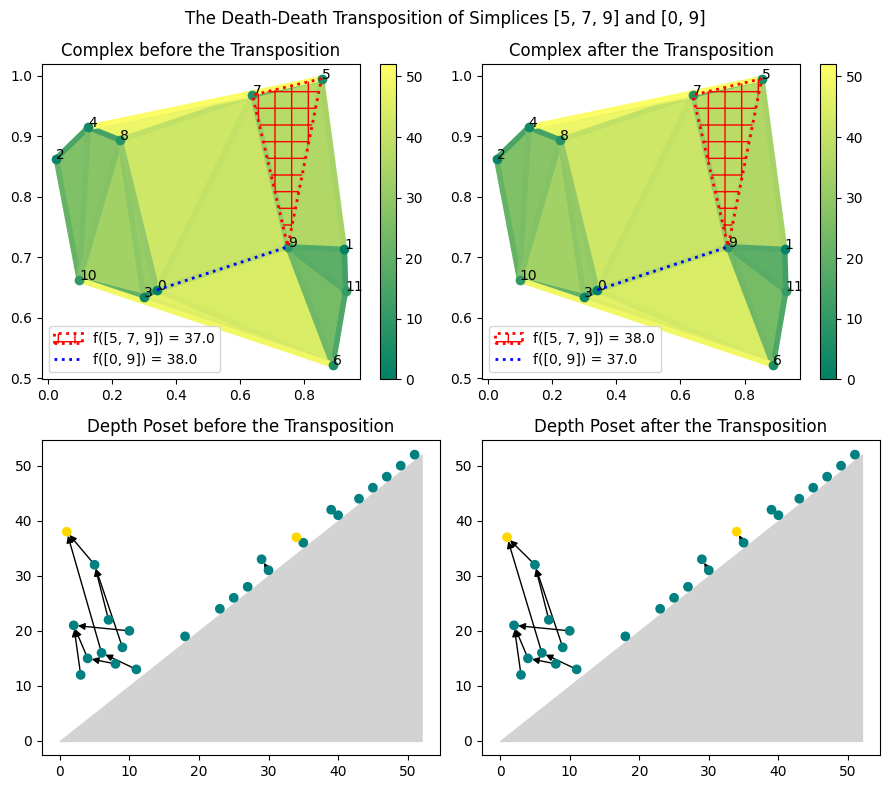

,score,descr,value
0,jacard_l32a,Jacard index of the sets: $\text{Succ}''(x...,0.0
1,jacard_l32b,Jacard index of the sets: $\text{Succ}''(a...,0.0


In [55]:
fig, axs = plot_transposition(transposition, stree0, stree1, dp0, dp1)
plt.tight_layout()
plt.show()


pd.DataFrame([{'score': f.__name__, 
               'descr': f.__doc__.replace('\n', ' ').strip(),
               'value': f(transposition, dp0, dp1)
              } for f in [jacard_l32a, jacard_l32b]])

## Lemma 3.3.
Suppose $(a, b)$ and $(x, y)$ are birth-death pairs of $f$: $X\to R$, $b, x$ are consecutive in the ordering by $f$, and the transposition of $b, x$ is a switch. Then
$$
\text{Succ}(a, x) = \text{Succ}(a, b)
\;\;\text{and}\;\; 
\text{Succ}(b, y) = \text{Succ}(x, y)
$$


In [56]:
transposition = df_transpositions.loc[np.random.choice(df_transpositions[df_transpositions['type'] == 'birth-death'].index)]

stree0, stree1 = get_strees(transposition, stree)

dp0 = DepthPoset.from_simplex_tree(stree0)
dp1 = DepthPoset.from_simplex_tree(stree1)

transposition

index 0               17
index 1               18
value 0             17.0
value 1             18.0
simplex 0         [1, 9]
simplex 1        [9, 11]
dim 0                  1
dim 1                  1
type         birth-death
Name: 17, dtype: object

In [57]:
pd.DataFrame({'dp0-bd': [(n.birth_value, n.death_value)  for n in dp0.nodes], 
              'dp1-bd': [(n.birth_value, n.death_value)  for n in dp1.nodes], 
              'dp0-source': [n.source for n in dp0.nodes], 
              'dp1-source': [n.source for n in dp1.nodes], 
              })

,dp0-bd,dp1-bd,dp0-source,dp1-source
0,"(51.0, 52.0)","(51.0, 52.0)","((4, 5), (4, 5, 7))","((4, 5), (4, 5, 7))"
1,"(49.0, 50.0)","(49.0, 50.0)","((6, 10), (3, 6, 10))","((6, 10), (3, 6, 10))"
2,"(47.0, 48.0)","(47.0, 48.0)","((4, 7), (4, 7, 8))","((4, 7), (4, 7, 8))"
3,"(45.0, 46.0)","(45.0, 46.0)","((3, 6), (0, 3, 6))","((3, 6), (0, 3, 6))"
4,"(43.0, 44.0)","(43.0, 44.0)","((0, 6), (0, 6, 9))","((0, 6), (0, 6, 9))"
5,"(40.0, 41.0)","(40.0, 41.0)","((0, 7), (0, 7, 9))","((0, 7), (0, 7, 9))"
6,"(39.0, 42.0)","(39.0, 42.0)","((7, 8), (0, 7, 8))","((7, 8), (0, 7, 8))"
7,"(35.0, 36.0)","(35.0, 36.0)","((5, 9), (1, 5, 9))","((5, 9), (1, 5, 9))"
8,"(34.0, 37.0)","(34.0, 37.0)","((1, 5), (5, 7, 9))","((1, 5), (5, 7, 9))"
9,"(30.0, 31.0)","(30.0, 31.0)","((0, 8), (0, 3, 8))","((0, 8), (0, 3, 8))"
